In [34]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [35]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [36]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[-0.26265531 -0.96488973  0.76414844]
[-1.2791892]
[-0.2699518  -0.96287384 -0.15139724] -3.4330158973920697 False {}


In [37]:
# Learning episodes
epochs = 1000

# Numbers of decimals for discretization
decimals = 1

Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


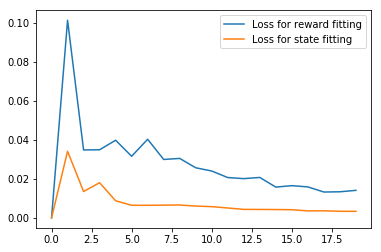

In [38]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

old_state = env.reset()

print("Regression...")
for i in range(epochs):
    #observation = env.reset() # do we really need to call this every episode?
    
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)

    rtx.append(np.append(old_state ,action))
    rty.append(reward)
    stx.append(np.append(old_state,action))
    sty.append(next_state)
    #observation = state
    if i%50==0: # 50 works nicely
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)
    
    old_state = np.copy(next_state)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [39]:
"""
    Discretization
    
    We translate the state from [-1, 1] [-1, 1] [-8, 8]
    to [0, 2] [0, 2] [0, 16]
    
    We translate the actions from [-2, 2] to [0, 4]
    
    Then we round the input with variable number of decimal places
    and multiply by 10 to the power of this number
    to make sure we get only positive integers
    
"""

def discretization(state_action, x, decimal_number):
    if state_action=="state":
        s = [x[0]+1, x[1]+1, x[2]+8]
        s = np.array([int(c*(10**decimal_number)) for c in s])
        return s
    if state_action=="action":
        a = x + 2
        a = [int(c*(10**decimal_number)) for c in a]
        return a
    else:
        print("Unknown discretization")
        return -1


In [40]:
discretization("state",[-0.03596892, 0.99769096, 0.94654325],2)

array([ 96, 199, 894])

In [41]:
"""
   Value Iteration
   
"""

'\n   Value Iteration\n   \n'

In [ ]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""

def policy_iteration(theta, gamma):
    
    # Determine size of value function and policy lookup table
    state_space_size = (2*(10**decimals), 2*(10**decimals), 16*(10**decimals))
    
    # Initialize value function and policy arbitrarily
    value_function = np.ones(shape=state_space_size)
    policy = np.ones(shape=state_space_size)
    
    print("Policy iteration...")
    
    def policy_evaluation(theta, gamma):
        print()
        print("Evaluating policy")
        delta = theta
        while delta >= theta:
            delta = 0
            for s0 in range(state_space_size[0]):
                for s1 in range(state_space_size[1]):
                    for s2 in range(state_space_size[2]):
                        v = value_function[s0, s1, s2]
                        
                        """
                         V(s) = Sum...p(s',r|s,pi(s))[r+gamma*V(s')]
                         
                        """
                        a = policy[s0, s1, s2]
                        # Maybe inefficient to iterate over all dimensions of s
                        # and then glue it back together
                        x = np.array([s0, s1, s2, a])
                        x = x.reshape(1,-1)
                        next_s = regressorState.predict(x).T
                        next_s = discretization("state", next_s, decimals)
                        r = regressorReward.predict(x)
                        value_function[s0, s1, s2] = r + gamma*value_function[next_s[0], next_s[1], next_s[2]]
                        
                        
                        delta = max(delta, v - value_function[s0, s1, s2])
            print("Delta: ", delta)
    
    
    def policy_improvement(gamma):
        print()
        print("Improving policy")
        policy_stable = True
        for s0 in range(state_space_size[0]):
                for s1 in range(state_space_size[1]):
                    for s2 in range(state_space_size[2]):
                        old_action = policy[s0, s1, s2]
                        
                        """
                            pi(s) = argmax_a ... 
                            We do not have to care about the prob. distribution,
                            as we have a deterministic env.
                            
                        """
                        # Iterate over all actions and get the one with max. expected reward
                        amax = 2
                        rmax = -100
                        for a in np.arange(0,4*(10**decimals)):
                            x = np.array([s0, s1, s2, a])
                            x = x.reshape(1,-1)
                            next_s = regressorState.predict(x).T
                            next_s = discretization("state", next_s, decimals)
                            r = regressorReward.predict(x)
                            expected_reward = r + gamma*value_function[next_s[0], next_s[1], next_s[2]]
                            if rmax < expected_reward:
                                amax = a
                                rmax = expected_reward 
                        policy[s0, s1, s2] = amax # TODO
                        
                        if old_action != policy[s0, s1, s2]:
                            policy_stable = False
                            
        print("Policy stable: ", policy_stable)
        return policy_stable
        
    # Run until policy is stable
    stable_policy = False
    while not stable_policy:
        policy_evaluation(theta, gamma)
        stable_policy = policy_improvement(gamma)
    
    print()
    print("...done")
    return value_function, policy
    
policy_iteration(theta=0.5, gamma=0.1)


In [ ]:
"""
    Some stuff to see the predictions and discretization in action

"""
state = env.reset()

for _ in range(10):
    #env.render()
    print("Old state: ", discretization("state", state, decimals))
    action = env.action_space.sample()
    print("Action: ", discretization("action", action, decimals))
    state, reward, done, info = env.step(action)
    x = np.append(state,action)
    x = x.reshape(1,-1)
    print("Predicted reward: ", regressorReward.predict(x))
    print("Observed reward: ", reward)
    print("Predicted next state: ", discretization("state", regressorState.predict(x).T, decimals))
    print("Observed next state: ", discretization("state", state, decimals))
    print()

env.close()